<a href="https://colab.research.google.com/github/prakharg8/Apartment-Design-with-gans/blob/main/disc_u2net_trial_U_2_netAppartement_program_design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**U2Net Model**

In [ ]:
# Arxiv: https://arxiv.org/pdf/2005.09007.pdf

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, ReLU, MaxPool2D, UpSampling2D

# Optimizer / Loss
adam = keras.optimizers.Adam(learning_rate=.001, beta_1=.9, beta_2=.999, epsilon=1e-08)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='model.ckpt', save_weights_only=True, verbose=1)
bce = keras.losses.BinaryCrossentropy()


class ConvBlock(keras.layers.Layer):
    def __init__(self, out_ch=3,dirate=1):
        super(ConvBlock, self).__init__()
        self.conv = Conv2D(out_ch, (3, 3), strides=1, padding='same', dilation_rate=dirate)
        self.bn = BatchNormalization()
        self.relu = ReLU()
    
    def call(self, inputs):
        hx = inputs

        x = self.conv(hx)
        x = self.bn(x)
        x = self.relu(x)

        return x

class RSU7(keras.layers.Layer):
    def __init__(self, mid_ch=12, out_ch=3):
        super(RSU7, self).__init__()
        self.conv_b0 = ConvBlock(out_ch, dirate=1)

        self.conv_b1 = ConvBlock(mid_ch, dirate=1)
        self.pool1   = MaxPool2D(2, strides=(2, 2))

        self.conv_b2 = ConvBlock(mid_ch, dirate=1)
        self.pool2   = MaxPool2D(2, strides=(2, 2))

        self.conv_b3 = ConvBlock(mid_ch, dirate=1)
        self.pool3   = MaxPool2D(2, strides=(2, 2))

        self.conv_b4 = ConvBlock(mid_ch, dirate=1)
        self.pool4   = MaxPool2D(2, strides=(2, 2))

        self.conv_b5 = ConvBlock(mid_ch, dirate=1)
        self.pool5   = MaxPool2D(2, strides=(2, 2))

        self.conv_b6 = ConvBlock(mid_ch, dirate=1)
        self.conv_b7 = ConvBlock(mid_ch, dirate=2)

        self.conv_b6_d  = ConvBlock(mid_ch, dirate=1)
        self.upsample_1 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.conv_b5_d  = ConvBlock(mid_ch, dirate=1)
        self.upsample_2 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.conv_b4_d  = ConvBlock(mid_ch, dirate=1)
        self.upsample_3 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.conv_b3_d  = ConvBlock(mid_ch, dirate=1)
        self.upsample_4 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.conv_b2_d  = ConvBlock(mid_ch, dirate=1)
        self.upsample_5 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.conv_b1_d  = ConvBlock(out_ch, dirate=1)
        self.upsample_6 = UpSampling2D(size=(2, 2), interpolation='bilinear')
    
    def call(self, inputs):
        hx = inputs
        hxin = self.conv_b0(hx)

        hx1 = self.conv_b1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.conv_b2(hx)
        hx = self.pool2(hx2)

        hx3 = self.conv_b3(hx)
        hx = self.pool3(hx3)

        hx4 = self.conv_b4(hx)
        hx = self.pool4(hx4)

        hx5 = self.conv_b5(hx)
        hx = self.pool5(hx5)

        hx6 = self.conv_b6(hx)

        hx7 = self.conv_b7(hx6)

        hx6d = self.conv_b6_d(tf.concat([hx7, hx6], axis=3))
        hx6dup = self.upsample_5(hx6d)

        hx5d = self.conv_b5_d(tf.concat([hx6dup, hx5], axis=3))
        hx5dup = self.upsample_4(hx5d)

        hx4d = self.conv_b4_d(tf.concat([hx5dup, hx4], axis=3))
        hx4dup = self.upsample_3(hx4d)

        hx3d = self.conv_b3_d(tf.concat([hx4dup, hx3], axis=3))
        hx3dup = self.upsample_2(hx3d)

        hx2d =  self.conv_b2_d(tf.concat([hx3dup, hx2], axis=3))
        hx2dup = self.upsample_1(hx2d)

        hx1d = self.conv_b1_d(tf.concat([hx2dup, hx1], axis=3))
        
        return hx1d + hxin

class RSU6(keras.layers.Layer):
    def __init__(self, mid_ch=12, out_ch=3):
        super(RSU6, self).__init__()
        self.conv_b0 = ConvBlock(out_ch, dirate=1)

        self.conv_b1 = ConvBlock(mid_ch, dirate=1)
        self.pool1   = MaxPool2D(2, strides=(2, 2))

        self.conv_b2 = ConvBlock(mid_ch, dirate=1)
        self.pool2   = MaxPool2D(2, strides=(2, 2))

        self.conv_b3 = ConvBlock(mid_ch, dirate=1)
        self.pool3   = MaxPool2D(2, strides=(2, 2))

        self.conv_b4 = ConvBlock(mid_ch, dirate=1)
        self.pool4   = MaxPool2D(2, strides=(2, 2))

        self.conv_b5 = ConvBlock(mid_ch, dirate=1)
        self.pool5   = MaxPool2D(2, strides=(2, 2))

        self.conv_b6 = ConvBlock(mid_ch, dirate=2)

        self.conv_b5_d = ConvBlock(mid_ch, dirate=1)
        self.upsample_1 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.conv_b4_d = ConvBlock(mid_ch, dirate=1)
        self.upsample_2 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.conv_b3_d = ConvBlock(mid_ch, dirate=1)
        self.upsample_3 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.conv_b2_d = ConvBlock(mid_ch, dirate=1)
        self.upsample_4 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.conv_b1_d = ConvBlock(out_ch, dirate=1)
        self.upsample_5 = UpSampling2D(size=(2, 2), interpolation='bilinear')
    
    def call(self, inputs):
        hx = inputs
        hxin = self.conv_b0(hx)

        hx1 = self.conv_b1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.conv_b2(hx)
        hx = self.pool2(hx2)

        hx3 = self.conv_b3(hx)
        hx = self.pool3(hx3)

        hx4 = self.conv_b4(hx)
        hx = self.pool4(hx4)

        hx5 = self.conv_b5(hx)

        hx6 = self.conv_b6(hx5)

        hx5d = self.conv_b5_d(tf.concat([hx6, hx5], axis=3))
        hx5dup = self.upsample_4(hx5d)

        hx4d = self.conv_b4_d(tf.concat([hx5dup, hx4], axis=3))
        hx4dup = self.upsample_3(hx4d)

        hx3d = self.conv_b3_d(tf.concat([hx4dup, hx3], axis=3))
        hx3dup = self.upsample_2(hx3d)

        hx2d =  self.conv_b2_d(tf.concat([hx3dup, hx2], axis=3))
        hx2dup = self.upsample_1(hx2d)

        hx1d = self.conv_b1_d(tf.concat([hx2dup, hx1], axis=3))
        
        return hx1d + hxin

class RSU5(keras.layers.Layer):
    def __init__(self, mid_ch=12, out_ch=3):
        super(RSU5, self).__init__()
        self.conv_b0 = ConvBlock(out_ch, dirate=1)

        self.conv_b1 = ConvBlock(mid_ch, dirate=1)
        self.pool1   = MaxPool2D(2, strides=(2, 2))

        self.conv_b2 = ConvBlock(mid_ch, dirate=1)
        self.pool2   = MaxPool2D(2, strides=(2, 2))

        self.conv_b3 = ConvBlock(mid_ch, dirate=1)
        self.pool3   = MaxPool2D(2, strides=(2, 2))

        self.conv_b4 = ConvBlock(mid_ch, dirate=1)
        self.pool4   = MaxPool2D(2, strides=(2, 2))

        self.conv_b5 = ConvBlock(mid_ch, dirate=2)

        self.conv_b4_d = ConvBlock(mid_ch, dirate=1)
        self.upsample_1 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.conv_b3_d = ConvBlock(mid_ch, dirate=1)
        self.upsample_2 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.conv_b2_d = ConvBlock(mid_ch, dirate=1)
        self.upsample_3 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.conv_b1_d = ConvBlock(out_ch, dirate=1)
        self.upsample_4 = UpSampling2D(size=(2, 2), interpolation='bilinear')
    
    def call(self, inputs):
        hx = inputs
        hxin = self.conv_b0(hx)

        hx1 = self.conv_b1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.conv_b2(hx)
        hx = self.pool2(hx2)

        hx3 = self.conv_b3(hx)
        hx = self.pool3(hx3)

        hx4 = self.conv_b4(hx)

        hx5 = self.conv_b5(hx4)

        hx4d = self.conv_b4_d(tf.concat([hx5, hx4], axis=3))
        hx4dup = self.upsample_3(hx4d)

        hx3d = self.conv_b3_d(tf.concat([hx4dup, hx3], axis=3))
        hx3dup = self.upsample_2(hx3d)

        hx2d =  self.conv_b2_d(tf.concat([hx3dup, hx2], axis=3))
        hx2dup = self.upsample_1(hx2d)

        hx1d = self.conv_b1_d(tf.concat([hx2dup, hx1], axis=3))
        
        return hx1d + hxin

class RSU4(keras.layers.Layer):
    def __init__(self, mid_ch=12, out_ch=3):
        super(RSU4, self).__init__()
        self.conv_b0 = ConvBlock(out_ch, dirate=1)

        self.conv_b1 = ConvBlock(mid_ch, dirate=1)
        self.pool1   = MaxPool2D(2, strides=(2, 2))

        self.conv_b2 = ConvBlock(mid_ch, dirate=1)
        self.pool2   = MaxPool2D(2, strides=(2, 2))

        self.conv_b3 = ConvBlock(mid_ch, dirate=1)
        self.pool3   = MaxPool2D(2, strides=(2, 2))

        self.conv_b4 = ConvBlock(mid_ch, dirate=2)

        self.conv_b3_d = ConvBlock(mid_ch, dirate=1)
        self.upsample_1 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.conv_b2_d = ConvBlock(mid_ch, dirate=1)
        self.upsample_2 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.conv_b1_d = ConvBlock(out_ch, dirate=1)
        self.upsample_3 = UpSampling2D(size=(2, 2), interpolation='bilinear')
    
    def call(self, inputs):
        hx = inputs
        hxin = self.conv_b0(hx)

        hx1 = self.conv_b1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.conv_b2(hx)
        hx = self.pool2(hx2)

        hx3 = self.conv_b3(hx)

        hx4 = self.conv_b4(hx3)

        hx3d = self.conv_b3_d(tf.concat([hx4, hx3], axis=3))
        hx3dup = self.upsample_2(hx3d)

        hx2d =  self.conv_b2_d(tf.concat([hx3dup, hx2], axis=3))
        hx2dup = self.upsample_1(hx2d)

        hx1d = self.conv_b1_d(tf.concat([hx2dup, hx1], axis=3))
        
        return hx1d + hxin

class RSU4F(keras.layers.Layer):
    def __init__(self, mid_ch=12, out_ch=3):
        super(RSU4F, self).__init__()
        self.conv_b0 = ConvBlock(out_ch, dirate=1)
        self.conv_b1 = ConvBlock(mid_ch, dirate=1)
        self.conv_b2 = ConvBlock(mid_ch, dirate=2)
        self.conv_b3 = ConvBlock(mid_ch, dirate=4)
        self.conv_b4 = ConvBlock(mid_ch, dirate=8)
        self.conv_b3_d = ConvBlock(mid_ch, dirate=4)
        self.conv_b2_d = ConvBlock(mid_ch, dirate=2)
        self.conv_b1_d = ConvBlock(out_ch, dirate=1)
    
    def call(self, inputs):
        hx = inputs
        hxin = self.conv_b0(hx)
        
        hx1 = self.conv_b1(hxin)
        hx2 = self.conv_b2(hx1)
        hx3 = self.conv_b3(hx2)
        hx4 = self.conv_b4(hx3)
        hx3d = self.conv_b3_d(tf.concat([hx4, hx3], axis=3))
        hx2d = self.conv_b2_d(tf.concat([hx3d, hx2], axis=3))
        hx1d = self.conv_b1_d(tf.concat([hx2d, hx1], axis=3))
        return hx1d + hxin

class U2NET(keras.models.Model):
    def __init__(self, out_ch=1):
        super(U2NET, self).__init__()
        
        self.stage1 = RSU7(32, 64)
        self.pool12 = MaxPool2D((2, 2), 2)

        self.stage2 = RSU6(32, 128)
        self.pool23 = MaxPool2D((2, 2), 2)

        self.stage3 = RSU5(64, 256)
        self.pool34 = MaxPool2D((2, 2), 2)

        self.stage4 = RSU4(128, 512)
        self.pool45 = MaxPool2D((2, 2), 2)

        self.stage5 = RSU4F(256, 512)
        self.pool56 = MaxPool2D((2, 2), 2)

        self.stage6 = RSU4F(256, 512)

        self.stage5d = RSU4F(256, 512)
        self.stage4d = RSU4(128, 256)
        self.stage3d = RSU5(64, 128)
        self.stage2d = RSU6(32, 64)
        self.stage1d = RSU7(16, 64)

        self.side1 = Conv2D(out_ch, (3, 3), padding='same')
        self.side2 = Conv2D(out_ch, (3, 3), padding='same')
        self.side3 = Conv2D(out_ch, (3, 3), padding='same')
        self.side4 = Conv2D(out_ch, (3, 3), padding='same')
        self.side5 = Conv2D(out_ch, (3, 3), padding='same')
        self.side6 = Conv2D(out_ch, (3, 3), padding='same')

        self.upsample_2 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_3 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_4 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_5 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_6 = UpSampling2D(size=(2, 2), interpolation='bilinear')

        self.upsample_out_2 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_out_3 = UpSampling2D(size=(4, 4), interpolation='bilinear')
        self.upsample_out_4 = UpSampling2D(size=(8, 8), interpolation='bilinear')
        self.upsample_out_5 = UpSampling2D(size=(16, 16), interpolation='bilinear')
        self.upsample_out_6 = UpSampling2D(size=(32, 32), interpolation='bilinear')

        self.outconv = Conv2D(out_ch, (1, 1), padding='same')
    
    def call(self, inputs):
        hx = inputs

        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        hx6 = self.stage6(hx)
        hx6up = self.upsample_6(hx6)
        side6 = self.upsample_out_6(self.side6(hx6))

        hx5d = self.stage5d(tf.concat([hx6up, hx5], axis=3))
        hx5dup = self.upsample_5(hx5d)
        side5 = self.upsample_out_5(self.side5(hx5d))

        hx4d = self.stage4d(tf.concat([hx5dup, hx4], axis=3))
        hx4dup = self.upsample_4(hx4d)
        side4 = self.upsample_out_4(self.side4(hx4d))

        hx3d = self.stage3d(tf.concat([hx4dup, hx3], axis=3))
        hx3dup = self.upsample_3(hx3d)
        side3 = self.upsample_out_3(self.side3(hx3d))

        hx2d = self.stage2d(tf.concat([hx3dup, hx2], axis=3))
        hx2dup = self.upsample_2(hx2d)
        side2 = self.upsample_out_2(self.side2(hx2d))

        hx1d = self.stage1d(tf.concat([hx2dup, hx1], axis=3))
        side1 = self.side1(hx1d)

        fused_output = self.outconv(tf.concat([side1, side2, side3, side4, side5, side6], axis=3))

        sig = keras.activations.sigmoid
        return tf.stack([sig(fused_output), sig(side1), sig(side2), sig(side3), sig(side4), sig(side5), sig(side6)], axis = 1)

class U2NETP(keras.models.Model):
    def __init__(self, out_ch=1):
        super(U2NETP, self).__init__()

        self.stage1 = RSU7(16, 64)
        self.pool12 = MaxPool2D((2, 2), 2)

        self.stage2 = RSU6(16, 64)
        self.pool23 = MaxPool2D((2, 2), 2)

        self.stage3 = RSU5(16, 64)
        self.pool34 = MaxPool2D((2, 2), 2)

        self.stage4 = RSU4(16, 64)
        self.pool45 = MaxPool2D((2, 2), 2)

        self.stage5 = RSU4F(16, 64)
        self.pool56 = MaxPool2D((2, 2), 2)

        self.stage6 = RSU4F(16, 64)
        self.side6 = Conv2D(out_ch, (3, 3), padding='same')

        self.stage5d = RSU4F(16, 64)
        self.side5 = Conv2D(out_ch, (3, 3), padding='same')

        self.stage4d = RSU4(16, 64)
        self.side4 = Conv2D(out_ch, (3, 3), padding='same')

        self.stage3d = RSU5(16, 64)
        self.side3 = Conv2D(out_ch, (3, 3), padding='same')

        self.stage2d = RSU6(16, 64)
        self.side2 = Conv2D(out_ch, (3, 3), padding='same')

        self.stage1d = RSU7(16, 64)
        self.side1 = Conv2D(out_ch, (3, 3), padding='same')

        self.upsample_2 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_3 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_4 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_5 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_6 = UpSampling2D(size=(2, 2), interpolation='bilinear')

        self.upsample_out_2 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_out_3 = UpSampling2D(size=(4, 4), interpolation='bilinear')
        self.upsample_out_4 = UpSampling2D(size=(8, 8), interpolation='bilinear')
        self.upsample_out_5 = UpSampling2D(size=(16, 16), interpolation='bilinear')
        self.upsample_out_6 = UpSampling2D(size=(32, 32), interpolation='bilinear')

        self.outconv = Conv2D(out_ch, 1)
    
    def call(self, inputs):
        hx = inputs
        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        hx6 = self.stage6(hx)
        hx6up = self.upsample_6(hx6)
        side6 = self.upsample_out_6(self.side6(hx6))

        hx5d = self.stage5d(tf.concat([hx6up, hx5], axis=3))
        hx5dup = self.upsample_5(hx5d)
        side5 = self.upsample_out_5(self.side5(hx5d))

        hx4d = self.stage4d(tf.concat([hx5dup, hx4], axis=3))
        hx4dup = self.upsample_4(hx4d)
        side4 = self.upsample_out_4(self.side4(hx4d))

        hx3d = self.stage3d(tf.concat([hx4dup, hx3], axis=3))
        hx3dup = self.upsample_3(hx3d)
        side3 = self.upsample_out_3(self.side3(hx3d))

        hx2d = self.stage2d(tf.concat([hx3dup, hx2], axis=3))
        hx2dup = self.upsample_2(hx2d)
        side2 = self.upsample_out_2(self.side2(hx2d))

        hx1d = self.stage1d(tf.concat([hx2dup, hx1], axis=3))
        side1 = self.side1(hx1d)

        fused_output = self.outconv(tf.concat([side1, side2, side3, side4, side5, side6], axis=3))

        sig = keras.activations.sigmoid
        return tf.keras.layers.Add()([sig(fused_output), sig(side1), sig(side2), sig(side3), sig(side4), sig(side5), sig(side6)])
      

In [ ]:

class U2NET_encoder(keras.models.Model):
    def __init__(self, out_ch=1):
        super(U2NET_encoder, self).__init__()
        
        self.stage1 = RSU7(32, 64)
        self.pool12 = MaxPool2D((2, 2), 2)

        self.stage2 = RSU6(32, 128)
        self.pool23 = MaxPool2D((2, 2), 2)

        self.stage3 = RSU5(64, 256)
        self.pool34 = MaxPool2D((2, 2), 2)

        self.stage4 = RSU4(128, 512)
        self.pool45 = MaxPool2D((2, 2), 2)

        self.stage5 = RSU4F(256, 512)
        self.pool56 = MaxPool2D((2, 2), 2)

        self.stage6 = RSU4F(256, 1)

            
    def call(self, inputs):

        # print(inputs.shape)
        hx = tf.keras.layers.concatenate([inputs[0], inputs[1]])
        # hx = inputs

        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        hx4 = self.stage4(hx)
        # hx = self.pool45(hx4)

        hx5 = self.stage5(hx)
        # hx = self.pool56(hx5)

        hx6 = self.stage6(hx)
        
        return hx6

In [ ]:
encoder = U2NET_encoder(out_ch = 3)

In [ ]:
image = tf.keras.layers.Input(shape=[256, 256, 3])
input = tf.keras.layers.Input(shape=[256, 256, 3])
output = encoder.call([image, input])

In [ ]:
import numpy as np
data = [input, image]
data[0].shape
# output.shape

TensorShape([None, 256, 256, 3])

In [ ]:
import tensorflow as tf
import os
import pathlib
import time
import datetime
import numpy as np
import cv2
from matplotlib import pyplot as plt
from IPython import display
from IPython.display import clear_output
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.utils import plot_model

In [ ]:
# pip install diagrams

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/appartment_design_program_dataset.zip", 'r')
zip_ref.extractall("/content/data")
zip_ref.close()

## **Build Generator**


In [ ]:
img = np.zeros((320,320,3))

In [ ]:
ADAM = keras.optimizers.Adam(learning_rate=0.001, beta_1=.9, beta_2=.999, epsilon=1e-08)
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=weights_file, save_weights_only=True, verbose=1)

In [ ]:
def __generator(out_ch):
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    net = U2NET(out_ch=3)
    out = net.call(inputs)
    model = keras.Model(inputs=inputs, outputs=out, name='u2netmodel')
    return model

    

In [ ]:
inputs = tf.keras.layers.Input(shape=[256, 256, 3])
net = U2NET(out_ch=3)
out = net.call(inputs)
model = keras.Model(inputs=inputs, outputs=out, name='u2netmodel')


In [ ]:
OUTPUT_CHANNELS=3
# # generator = Generator()
# u2net = U2NETP(OUTPUT_CHANNELS,1);
# adam = keras.optimizers.Adam(learning_rate=.001, beta_1=.9, beta_2=.999, epsilon=1e-08)
# 
# inputs = tf.keras.layers.Input(shape=[256, 256, 3])
generator = __generator(OUTPUT_CHANNELS)

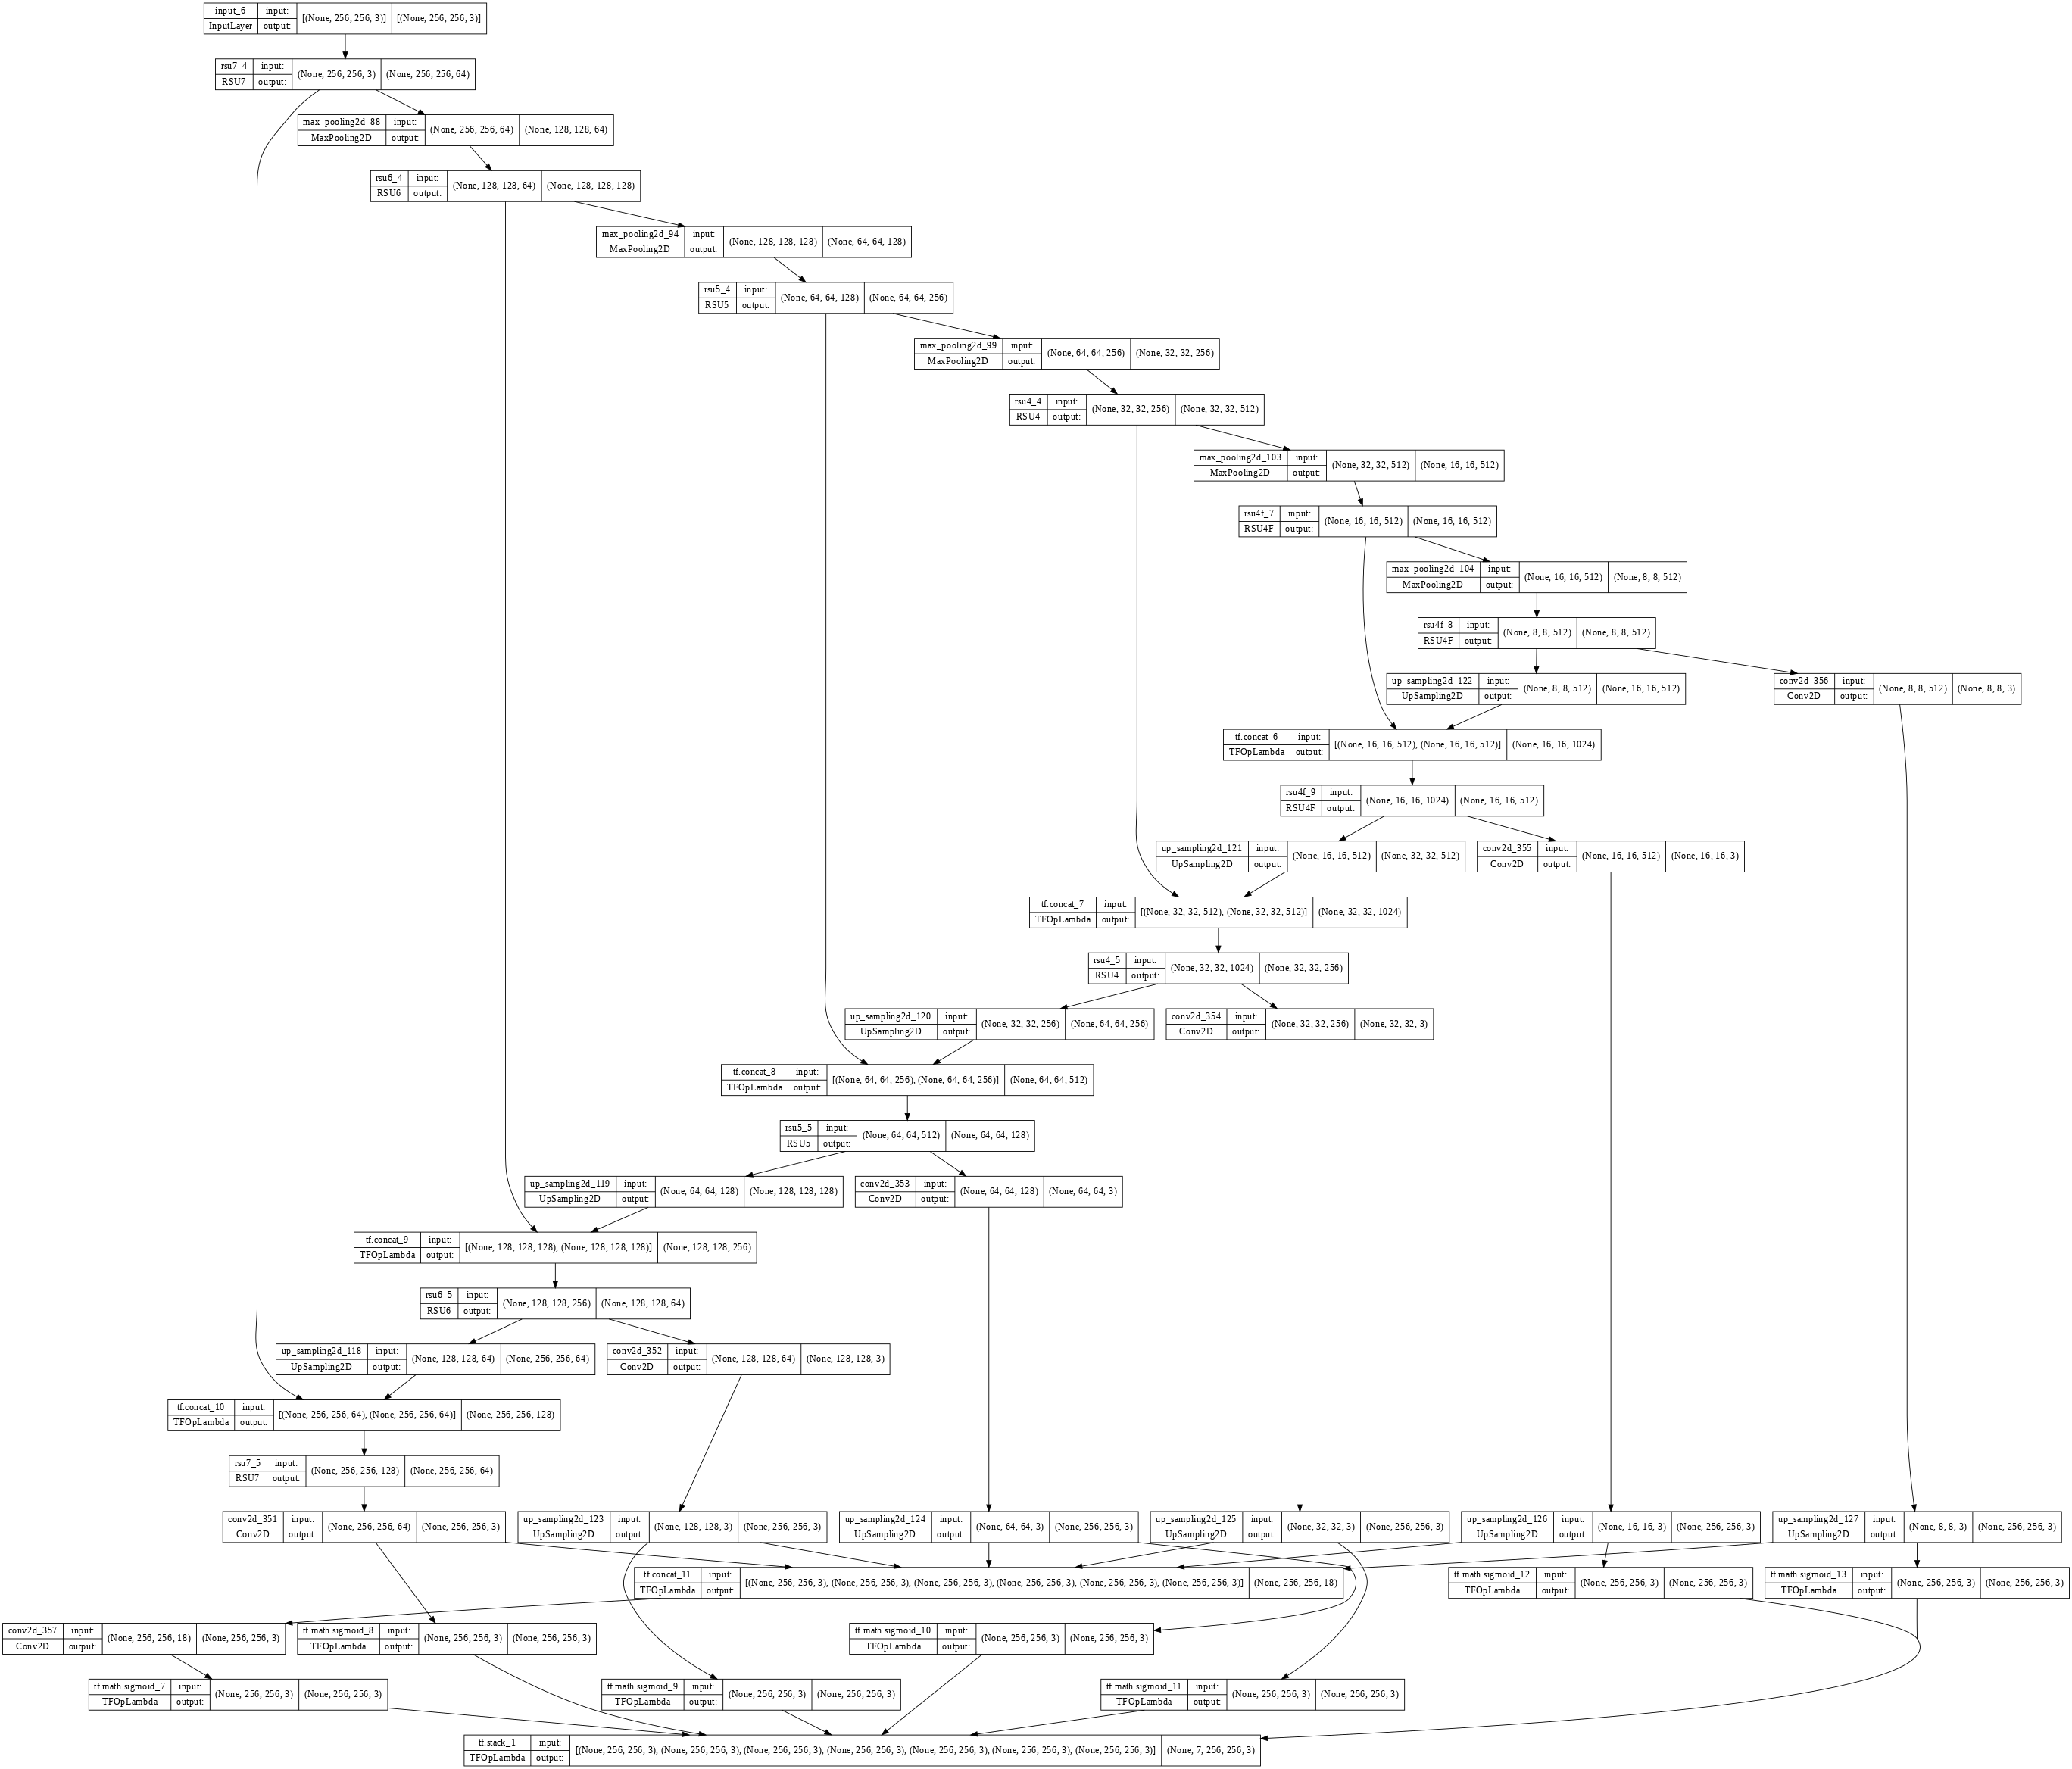

In [ ]:
# # net = U2NETP(out_ch)
# #     out = net.call(inputs)
# #     model = keras.Model(inputs=inputs, outputs=out, name='u2netmodel')
# OUTPUT_CHANNELS=3
# # # generator = Generator()
# # u2net = U2NETP(OUTPUT_CHANNELS,1);
# # adam = keras.optimizers.Adam(learning_rate=.001, beta_1=.9, beta_2=.999, epsilon=1e-08)
# # 
# # inputs = tf.keras.layers.Input(shape=[256, 256, 3])
# generator = __generator(OUTPUT_CHANNELS)
# # generator.summary()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [ ]:
# import keras_util
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers.core import Dense, Dropout, Activation, Flatten

In [ ]:
def l1(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))
def l1_loss(y_true, y_pred):
    loss0 = l1(y_true, y_pred[:,0])
    loss1 = l1(y_true, y_pred[:,1])
    loss2 = l1(y_true, y_pred[:,2])
    loss3 = l1(y_true, y_pred[:,3])
    loss4 = l1(y_true, y_pred[:,4])
    loss5 = l1(y_true, y_pred[:,5])
    loss6 = l1(y_true, y_pred[:,6])
    return loss0 + loss1 + loss2 + loss3 + loss4 + loss5 + loss6

In [ ]:
def depth_gradient(y_true, y_pred):
    # print("starting ", y_true.shape)
    y_true = tf.image.convert_image_dtype(y_true, dtype=tf.float32)
    # y_true = tf.expand_dims(y_true, axis = 3)
    y_pred = tf.image.convert_image_dtype(y_pred, dtype = tf.float32)
    # y_pred = tf.expand_dims(y_pred, axis = 3)
    # print("ending ", y_true.shape)
    #y_true edges

    sobel_true = tf.image.sobel_edges(y_true)
    sobel_true_h = sobel_true[0, :, :, 0]
    sobel_true_w = sobel_true[0, :, :, 1]
    #y_pred edges
    sobel_pred = tf.image.sobel_edges(y_pred)
    sobel_pred_h = sobel_pred[0, :, :, 0]
    sobel_pred_w = sobel_pred[0, :, :, 1]
    loss_depth = tf.reduce_mean(tf.math.abs(sobel_pred_h - sobel_true_h) + tf.math.abs(sobel_pred_w - sobel_true_w))
#     N = y_true.shape[1]
#     loss_depth = loss_depth/(N * N)
    return loss_depth

In [ ]:
def depth_gradient_loss(y_true, y_pred):
    loss0 = depth_gradient(y_true, y_pred[:,0])
    loss1 = depth_gradient(y_true, y_pred[:,1])
    loss2 = depth_gradient(y_true, y_pred[:,2])
    loss3 = depth_gradient(y_true, y_pred[:,3])
    loss4 = depth_gradient(y_true, y_pred[:,4])
    loss5 = depth_gradient(y_true, y_pred[:,5])
    loss6 = depth_gradient(y_true, y_pred[:,6])
    return loss0 + loss1 + loss2 + loss3 + loss4 + loss5 + loss6

In [ ]:

# def bce_loss(y_true, y_pred):
#     # y_pred = tf.expand_dims(y_pred, axis=-1)
#     loss0 = bce(y_true, y_pred[:,0])
#     loss1 = bce(y_true, y_pred[:,1])
#     loss2 = bce(y_true, y_pred[:,2])
#     loss3 = bce(y_true, y_pred[:,3])
#     loss4 = bce(y_true, y_pred[:,4])
#     loss5 = bce(y_true, y_pred[:,5])
#     loss6 = bce(y_true, y_pred[:,6])
#     return loss0 + loss1 + loss2 + loss3 + loss4 + loss5 + loss6


In [ ]:

img = np.zeros((10,256,256,3))
output = model(img)


In [ ]:
value  = depth_gradient_loss(img, output)

In [ ]:
print(value)

tf.Tensor(0.0, shape=(), dtype=float32)


In [ ]:
output.shape

TensorShape([10, 7, 256, 256, 3])

In [ ]:
LAMBDA = 100
BETA = 10
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
# value = bce(tf.ones_like(another_output), another_output)
# print(value)x

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  disc_generated_output = tf.convert_to_tensor(disc_generated_output, dtype = tf.float32) 
  gen_output = tf.convert_to_tensor(gen_output, dtype = tf.float32) 
  # target = tf.convert_to_tensor(target, dtype = tf.float32) 
  gan_loss = bce(tf.ones_like(disc_generated_output), disc_generated_output)
  l1_loss_out = l1_loss(target, gen_output)
  total_gen_loss = gan_loss + (LAMBDA * l1_loss_out)+ (BETA)*depth_gradient_loss(target, gen_output)
  return total_gen_loss, gan_loss, l1_loss

In [ ]:
another_output = np.zeros((10, 7,30,30,1))
generator_loss(another_output,output,img)

(<tf.Tensor: shape=(), dtype=float32, numpy=365.42496>,
 <tf.Tensor: shape=(), dtype=float32, numpy=15.424949>,
 <function __main__.l1_loss>)

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())
  return result

In [ ]:
# def Discriminator():
#     initializer = tf.random_normal_initializer(0., 0.02)

#     inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
#     tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

#     x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

#     down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
#     down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
#     down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

#     zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
#     conv = tf.keras.layers.Conv2D(512, 4, strides=1,
#                                   kernel_initializer=initializer,
#                                   use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

#     batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

#     leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

#     zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

#     last = tf.keras.layers.Conv2D(1, 4, strides=1,
#                                   kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

#     return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [ ]:
def u2net_discriminator(out_ch):
    input_pred = tf.keras.layers.Input(shape=[256, 256, 3])
    image_gt = tf.keras.layers.Input(shape=[256, 256, 3])
    net = U2NET_encoder(out_ch = 3)
    out = net.call([input_pred, image_gt])
    model2 = keras.Model(inputs=[input_pred, image_gt], outputs=out, name='u2netdisc')
    return model2


In [ ]:
discriminator = u2net_discriminator(out_ch = 3)
discriminator.summary()

Model: "u2netdisc"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_10 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_3 (Concatenate)    (None, 256, 256, 6)  0           ['input_9[0][0]',                
                                                                  'input_10[0][0]']       

In [ ]:
img = np.zeros((10,256,256,3))
ground_truth = np.zeros((10, 256, 256, 3))
value = discriminator([img, ground_truth])

In [ ]:
print(value.shape)

(10, 32, 32, 1)


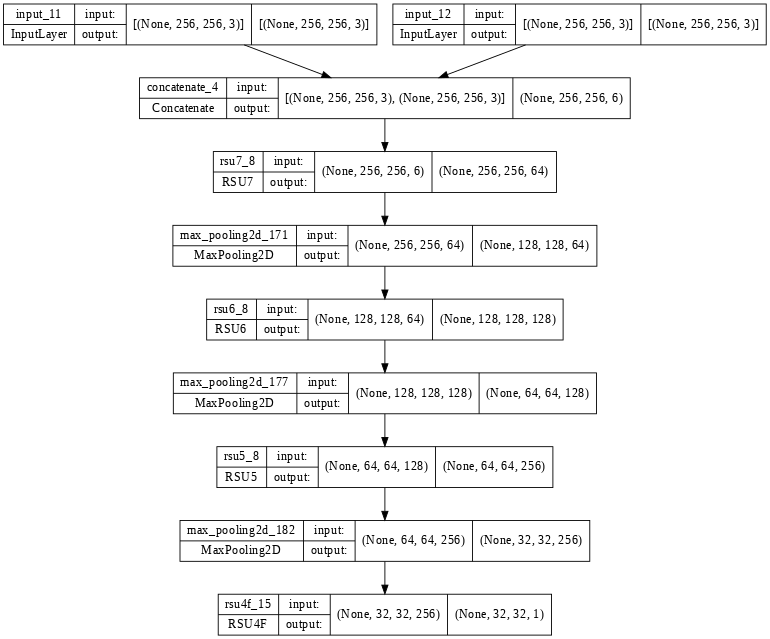

In [ ]:
discriminator = u2net_discriminator(out_ch = 3)
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss
  

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
path = "/content/drive/MyDrive/u2net/disc_u2net_encoder"
try:
  os.mkdir(path)
except Exception as e:
  print(e)

[Errno 17] File exists: '/content/drive/MyDrive/u2net/disc_u2net_encoder'


In [ ]:
checkpoint_dir = '/content/drive/MyDrive/u2net/disc_u2net_encoder/checkpoints'
try:
  os.mkdir(checkpoint_dir)
except Exception as e:
  print(e)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

[Errno 17] File exists: '/content/drive/MyDrive/u2net/disc_u2net_encoder/checkpoints'


In [ ]:
# os.listdir("/content/drive/MyDrive/appartment_program_checkpoints_updated/")

In [ ]:
# checkpoint.restore("/content/drive/MyDrive/new_u2net_apartment/checkpoints/ckpt01-1")

In [ ]:
# import shutil
# shutil.copy("/content/drive/MyDrive/appartment_program_checkpoints_updated/ckpt481-75.data-00000-of-00001", "/content/drive/MyDrive")

In [ ]:
log_dir="/content/drive/MyDrive/u2net/disc_u2net_encoder/logs/"
try:
  os.mkdir(log_dir)
except Exception as e:
  print(e)
summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

[Errno 17] File exists: '/content/drive/MyDrive/u2net/disc_u2net_encoder/logs/'


In [ ]:
@tf.function
def train_step(input_image, target):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)

    disc_generated_output = discriminator([input_image, gen_output[:,0]], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
  print("gen_total_loss:{}, gen_l1_loss {}, disc_total_loss{}".format(gen_total_loss, gen_l1_loss, disc_loss))


In [ ]:
import tensorflow as tf
import numpy as np
import random
import cv2
import os,sys
from PIL import Image
import scipy.misc

class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, x_data, y_data, shape=None, batch_size=None, shuffle=None):
    self.shape = shape
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.x_data = x_data
    self.y_data = y_data
    # self.on_epoch_end()

  # def on_epoch_end(self):
  #   if self.shuffle:
  #     temp = [i for i in range(len(self.real))]
  #     random.shuffle(temp)
  #     self.real = [self.real[i] for i in temp]
  #     self.depth = [self.depth[i] for i in temp]

  def __getitem__(self, index):
    # print(index)
    start_index = index * self.batch_size
    input_image = []
    y_true = []
    i = start_index -1
    while len(y_true) < self.batch_size:
      try:
        i += 1
        # print(i)
        rgb = cv2.imread(self.x_data[i % len(self.x_data)])
        rgb = cv2.resize(rgb, (256, 256))
        rgb = rgb/255.0
        # rgb = np.ones((256,256,3),dtype = np.float32)
        # print("rgb")
        output = cv2.imread(self.y_data[i % len(self.y_data)])
        output = cv2.resize(output, (256,256))
        output = output/255.0
        
        input_image.append(rgb)
        y_true.append(output)

      except Exception as err:
        print(err)
        continue
    return np.array(input_image), np.array(y_true)# - 1

  def __len__(self):
    return int(np.floor(len(self.y_data) / self.batch_size))

In [ ]:
x_data = []
y_data = []
print(y_data)
input_folder_path = "/content/data/appartment_design_program_dataset/input_image"
output_folder_path = "/content/data/appartment_design_program_dataset/output_image"
# path = "/content/drive/MyDrive/dataset_appartment_design"
for y_img  in os.listdir(input_folder_path):
    y_path = os.path.join(output_folder_path, y_img)
    x_path = os.path.join(input_folder_path, y_img)
    print(x_path, y_path)
    x_data.append(x_path)
    y_data.append(y_path)
print(y_data)
x_data = np.array(x_data)
y_data = np.array(y_data)

[]
/content/data/appartment_design_program_dataset/input_image/405.png /content/data/appartment_design_program_dataset/output_image/405.png
/content/data/appartment_design_program_dataset/input_image/605.png /content/data/appartment_design_program_dataset/output_image/605.png
/content/data/appartment_design_program_dataset/input_image/543.png /content/data/appartment_design_program_dataset/output_image/543.png
/content/data/appartment_design_program_dataset/input_image/323.png /content/data/appartment_design_program_dataset/output_image/323.png
/content/data/appartment_design_program_dataset/input_image/276.png /content/data/appartment_design_program_dataset/output_image/276.png
/content/data/appartment_design_program_dataset/input_image/517.png /content/data/appartment_design_program_dataset/output_image/517.png
/content/data/appartment_design_program_dataset/input_image/216.png /content/data/appartment_design_program_dataset/output_image/216.png
/content/data/appartment_design_progra

In [ ]:
print(len(x_data))
print(len(y_data))

679
679


In [ ]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0,0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

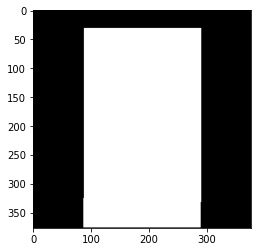

In [ ]:
img = cv2.imread(x_data[0])
plt.imshow(img,cmap='gray')

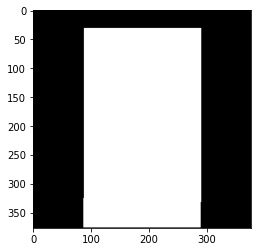

In [ ]:
y_img = cv2.imread(y_data[0])
plt.imshow(img,cmap='gray')

In [ ]:
input_shape= (256,256)

In [ ]:

# y_img = cv2.imread(y_data[168])
# y_img = cv2.cvtColor(y_img, cv2.COLOR_BGR2GRAY)
# y_img[:2], y_img[-2:], y_img[:,:2],  y_img[:,-2:]=0,0,0,0
# # print(y_img.shape)
# img = np.ones(y_img.shape)*255
# img[:2]=0
# img[-2:]=0
# img[:,:2]=0
# img[:,-2:]=0
# print(y_img.shape)

# x, y = y_img.shape[0],y_img.shape[1]
# x = max(0,(input_shape[0] - img.shape[0])//2)
# y = max(0,(input_shape[1] - img.shape[1])//2)
# model_input_img = np.ones((input_shape[0],input_shape[1]))*255
# model_input_img[x:x+img.shape[0],y:y+img.shape[1]]=img
# model_output_img = np.ones((input_shape[0],input_shape[1]),dtype=np.float32)*255
# model_output_img[x:x+img.shape[0],y:y+img.shape[1]]=y_img


In [ ]:
# input_folder_path = "/content/drive/MyDrive/Appartment_design/input_image"
# output_folder_path = "/content/drive/MyDrive/Appartment_design/output_image"

# os.mkdir("/content/drive/MyDrive/Appartment_design")
# os.mkdir(input_folder_path)
# os.mkdir(output_folder_path)
# for y_img_path in y_data:
#   try:
#     y_img = cv2.imread(y_img_path)
#     y_img = cv2.cvtColor(y_img, cv2.COLOR_BGR2GRAY)
#     y_img[:2], y_img[-2:], y_img[:,:2],  y_img[:,-2:]=0,0,0,0
#     # print(y_img.shape)
#     img = np.ones(y_img.shape)*255
#     img[:2]=0
#     img[-2:]=0
#     img[:,:2]=0
#     img[:,-2:]=0
#     # print(y_img.shape)

#     x, y = y_img.shape[0],y_img.shape[1]
#     x = max(0,(input_shape[0] - img.shape[0])//2)
#     y = max(0,(input_shape[1] - img.shape[1])//2)
#     model_input_img = np.ones((input_shape[0],input_shape[1]))*255
#     model_input_img[x:x+img.shape[0],y:y+img.shape[1]]=img
#     model_output_img = np.ones((input_shape[0],input_shape[1]),dtype=np.float32)*255
#     model_output_img[x:x+img.shape[0],y:y+img.shape[1]]=y_img

#     input_image_name = y_img_path.split("/")[-1]
#     model_input_path = os.path.join(input_folder_path, input_image_name)
#     model_output_path = os.path.join(output_folder_path, input_image_name)
#     cv2.imwrite(model_input_path,model_input_img)
#     cv2.imwrite(model_output_path,model_output_img)
#   except Exception as e:
#     print(e)

In [ ]:
# plt.imshow(y_img,cmap='gray')
# print(y_img.shape)

In [ ]:
# print(model_output_img)

In [ ]:
# plt.imshow(model_input_img,cmap='gray')

In [ ]:
# plt.imshow(model_output_img, cmap='gray')

In [ ]:
# plt.imshow(img)

In [ ]:
# print(img[:2])

In [ ]:
train_data = DataGenerator(x_data, y_data, shape = (256,256),batch_size=1) 

In [ ]:
def fit(train_ds, epochs):
  steps_per_epoch = len(y_data)//batch_size
  start = time.time()

  for i in range(epochs):
    print("Epoch : ", i + 1)
    
    for j in range(steps_per_epoch):
      # print(j)
      a = train_data.__getitem__(j)
      # print("OK")
      train_step(a[0], a[1])
      if (j+1) % 20 == 0:
        ran = random.randint(0, len(x_data))
        test = train_data.__getitem__(ran)
        generate_images(generator, test[0], test[1])

    if i%2 ==0:
      checkpoint.save(file_prefix=checkpoint_prefix + str(i)+'1')     
      clear_output()



Epoch :  6
gen_total_loss:93.260009765625, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9396927356719971
gen_total_loss:153.00225830078125, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9491472244262695
gen_total_loss:105.54071044921875, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.954688310623169
gen_total_loss:87.92627716064453, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9806759357452393
gen_total_loss:110.92015838623047, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9569971561431885
gen_total_loss:80.26753997802734, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9561529159545898
gen_total_loss:144.2642059326172, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9505000114440918
gen_total_loss:91.76722717285156, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9443656206130981
gen_total_loss:123.9269027709961, gen_l1_loss

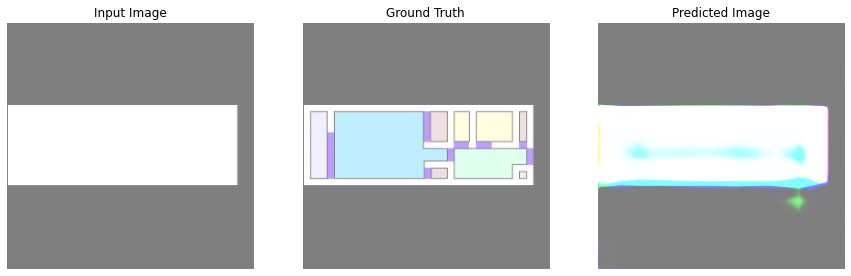

gen_total_loss:157.42807006835938, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9476460814476013
gen_total_loss:168.27688598632812, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9623197913169861
gen_total_loss:81.60619354248047, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9453816413879395
gen_total_loss:94.39656066894531, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9483913779258728
gen_total_loss:75.78446960449219, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9422283172607422
gen_total_loss:92.00543212890625, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9425113201141357
gen_total_loss:72.67845916748047, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9386314153671265
gen_total_loss:110.33671569824219, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9421027898788452
gen_total_loss:146.1702117919922, gen_l1_loss <functi

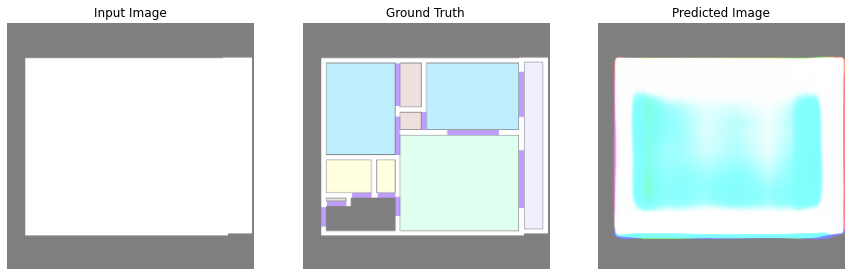

gen_total_loss:97.97538757324219, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.948276698589325
gen_total_loss:68.83406066894531, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.94203782081604
gen_total_loss:134.9123077392578, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9574145674705505
gen_total_loss:144.28924560546875, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9435880184173584
gen_total_loss:118.63639831542969, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9384639263153076
gen_total_loss:58.80202102661133, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9394881129264832
gen_total_loss:121.16151428222656, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9624032974243164
gen_total_loss:87.36442565917969, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9420728087425232
gen_total_loss:181.38990783691406, gen_l1_loss <function

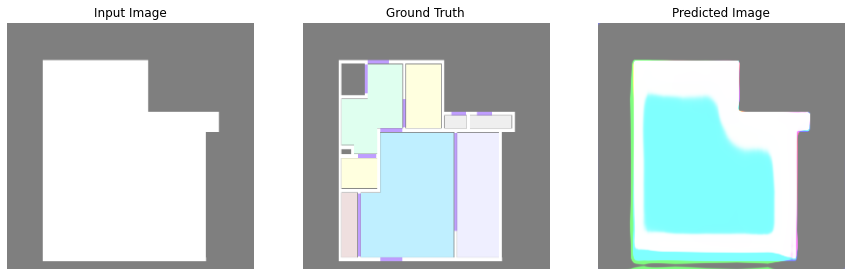

gen_total_loss:97.66317749023438, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9414015412330627
gen_total_loss:108.24867248535156, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9405438899993896
gen_total_loss:137.59446716308594, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.94498610496521
gen_total_loss:96.22175598144531, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9417495131492615
gen_total_loss:190.8682403564453, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9391984939575195
gen_total_loss:141.26651000976562, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9488117694854736
gen_total_loss:85.37125396728516, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9379849433898926
gen_total_loss:135.69873046875, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9391586780548096
gen_total_loss:108.87468719482422, gen_l1_loss <function 

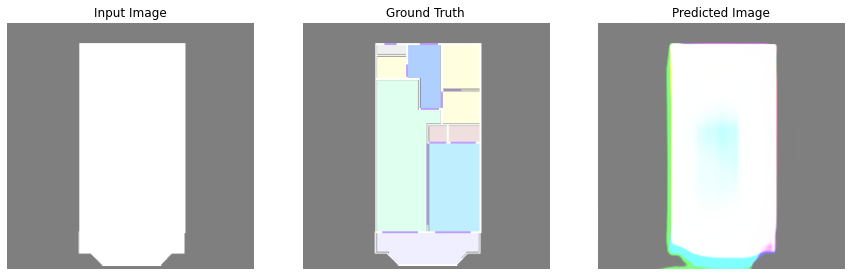

gen_total_loss:121.91868591308594, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9377486109733582
gen_total_loss:127.79698944091797, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9418321251869202
gen_total_loss:134.55667114257812, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9431052207946777
gen_total_loss:89.14331817626953, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9338933229446411
gen_total_loss:86.42432403564453, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9383569955825806
gen_total_loss:127.18852996826172, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9401920437812805
gen_total_loss:80.4498291015625, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9339090585708618
gen_total_loss:125.26483917236328, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9338878393173218
gen_total_loss:178.28506469726562, gen_l1_loss <func

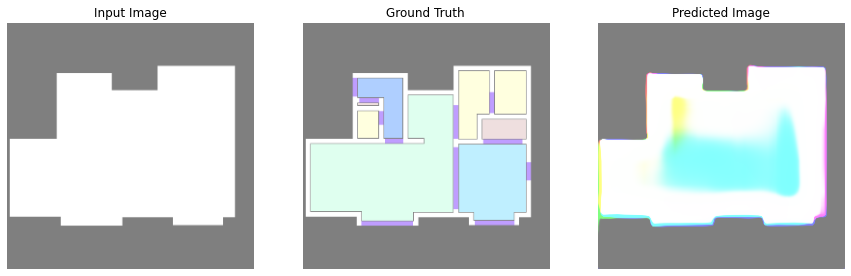

gen_total_loss:155.02865600585938, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9378467798233032
gen_total_loss:111.34359741210938, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9378879070281982
gen_total_loss:281.7655029296875, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9464976787567139
gen_total_loss:137.24867248535156, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9344466328620911
gen_total_loss:117.67398834228516, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9346537590026855
gen_total_loss:87.92431640625, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9372913837432861
gen_total_loss:149.82081604003906, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9405373334884644
gen_total_loss:98.31695556640625, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9356211423873901
gen_total_loss:96.55645751953125, gen_l1_loss <functio

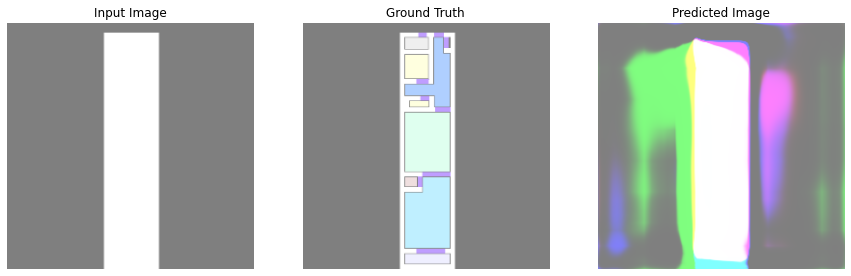

gen_total_loss:85.74263000488281, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9380637407302856
gen_total_loss:249.0059814453125, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9438736438751221
gen_total_loss:126.72444915771484, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9352611899375916
gen_total_loss:138.41018676757812, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9370138049125671
gen_total_loss:87.92322540283203, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9357547760009766
gen_total_loss:103.97093200683594, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.934344470500946
gen_total_loss:115.89479064941406, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9319649934768677
gen_total_loss:124.13594055175781, gen_l1_loss <function l1_loss at 0x7fc0343a0cb0>, disc_total_loss0.9361538887023926
gen_total_loss:110.76419067382812, gen_l1_loss <func

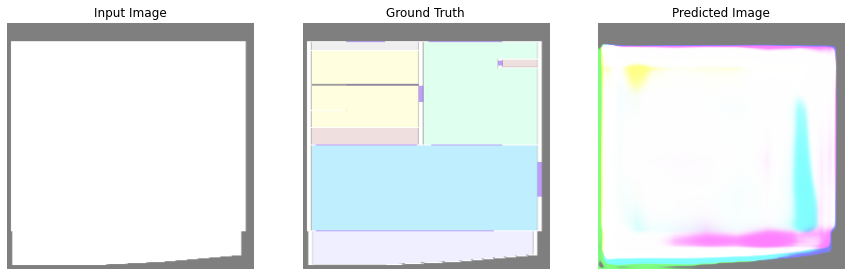

KeyboardInterrupt: ignored

In [ ]:
tf.config.experimental_run_functions_eagerly(True)
batch_size = 1
fit(train_data, epochs=50)

In [ ]:
!nvidia-smi

In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)

In [ ]:
test_val = train_data.__getitem__(5)

In [ ]:
plt.imshow(test_val[0][0])

In [ ]:
generate_images(generator, test_val[0], test_val[1])

In [ ]:
plt.imshow(test_val[1][0])

In [ ]:
np.array(test_val).shape

In [ ]:
print(tf.__version__)

In [ ]:
ran = random.randint(0, len(x_data))
test = train_data.__getitem__(ran)
generate_images(generator, test[0], test[1])
# generate_images(generator, test[], test[1])